In [1]:
! head ./data/ml-1m/ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


In [2]:
import numpy as np
import random
from tqdm import tqdm
from rank_metrics import ndcg_at_k
from sklearn.metrics import roc_auc_score

In [3]:
raw_data = np.loadtxt('./data/ml-1m/ratings.dat', delimiter='::')

In [4]:
class TriplesDataset(object):
    
    def __init__(self, raw_data, threshold_user = 20, threshold_item = 5, rnd_seed = 42):
        self.threshold_user = threshold_user
        self.threshold_item = threshold_item
        
        self.N_ITEMS = int(max(raw_data[:, 1]))
        
        # fix randomness
        self.seed = rnd_seed
        np.random.seed(rnd_seed)
        random.seed(rnd_seed)
        
        # calculate item counts
        i_cnt = {}
        for row in tqdm(raw_data, desc='Calculate items counts', leave=False):
            u, i, r, t = row.astype(int)
            i_cnt[i] = i_cnt.get(i, 0) + 1
        i_blacklist = set([k for k, v in i_cnt.items() if v < threshold_item])
        self.used_items = set([k for k, v in i_cnt.items() if v >= threshold_item])
        
        # calculate item counts
        u_cnt = {}
        for row in tqdm(raw_data, desc='Calculate users counts', leave=False):
            u, i, r, t = row.astype(int)
            if i not in i_blacklist:
                u_cnt[u] = u_cnt.get(u, 0) + 1
        u_blacklist = set([k for k, v in u_cnt.items() if v < threshold_user])
        self.used_users = set([k for k, v in u_cnt.items() if v >= threshold_user])
        
        
        # assemble self.data like {user:[(item, rating),...], ...}
        self.data = {}
        for row in tqdm(raw_data, desc='Assemble .data', leave=False):
            u, i, r, t = list(map(int, row))
            # filtering rare
            if (u in u_blacklist) or (i in i_blacklist):
                continue
            self.data[u] = self.data.get(u, []) + [(i, r)]
        self.data_keys = list(self.data.keys())
    
    
    def train_test_split(self, n_train):
        
        # .train : {user: {rating: [items, ...], ...}}
        self.train = {}
            
        # .test : {user: [(item, rating), ..]} [sorted by rating]
        self.test = {}
            
        for u in tqdm(self.data, desc='Split users', leave=False):
            rnd_inds = set(np.random.choice(len(self.data[u]), n_train, False))
            for n, pair in enumerate(self.data[u]):
                if n in rnd_inds:
                    i, r = pair
                    user_dict = self.train.get(u, {})
                    rating_list = user_dict.get(r, [])
                    rating_list.append(i)
                    user_dict[r] = rating_list
                    self.train[u] = user_dict
                else:
                    self.test[u] = self.test.get(u, []) + [pair]
            if len(self.train[u].keys())==1:
                print('No rating diversity in train for user {}, do swap!'.format(u))
                the_only_rating = list(self.train[u].keys())[0]
                for n, (i, r) in enumerate(self.test[u]):
                    if r!=the_only_rating:
                        self.train[u][r] = [i]
                        extracted_i = self.train[u][the_only_rating][0]
                        self.train[u][the_only_rating] = self.train[u][the_only_rating][1:]
                        del self.test[u][n]
                        self.test[u] = self.test[u] + [(extracted_i, the_only_rating)]
                        break
            self.test[u] = sorted(self.test[u], key=lambda x: x[1], reverse=True)
                    
    def sample_train_triple(self):
        user = random.choice(self.data_keys)
        stats = self.train[user]
        stats_keys = list(stats.keys())
        assert len(stats_keys) > 1, 'user {} has only 1 rating!'.format(user)
          
        def sampler(rating, stats):
            return random.choice(stats[rating])
                
        left_rating, right_rating = random.sample(stats_keys, 2)
        left_value = sampler(left_rating, stats)
        right_value = sampler(right_rating, stats)
        y = (left_rating > right_rating)*2 - 1
        return (user, left_value, right_value, y)
    
    
    def sample_train_batch(self,n_samples=256):
        retval = np.zeros((n_samples, 4)).astype(np.int32)
        for i in range(n_samples):
            retval[i] = self.sample_train_triple()
        return {
            'users': retval[:, 0], 
            'left_items': retval[:, 1],
            'right_items': retval[:, 2],
            'y': retval[:, 3].astype(np.float32),
        }

In [5]:
ds = TriplesDataset(raw_data, threshold_user=30, rnd_seed=142)
ds.train_test_split(n_train=20)

Split users:  67%|██████▋   | 3540/5286 [00:00<00:00, 3805.65it/s]                unts:   5%|▌         | 52094/1000209 [00:00<00:01, 520936.77it/s]

No rating diversity in train for user 3598, do swap!


Split users:  99%|█████████▉| 5250/5286 [00:01<00:00, 4085.76it/s]Split users:  83%|████████▎ | 4370/5286 [00:01<00:00, 3847.14it/s]

No rating diversity in train for user 4486, do swap!


In [8]:
len(ds.used_users)

5286

# define model

In [9]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [10]:
tf.__version__

'0.12.0-rc1'

In [11]:
N_USERS = int(max(raw_data[:, 0])) + 1
N_ITEMS = int(max(raw_data[:, 1])) + 1
N_HIDDEN = 10

In [12]:
# placeholders
user_ids  = tf.placeholder(tf.int32, (None,), name='user_ids')
left_ids  = tf.placeholder(tf.int32, (None,), name='left_ids')
right_ids = tf.placeholder(tf.int32, (None,), name='right_ids')
target_y  = tf.placeholder(tf.float32, (None,), name='target_y')


# main parameters
user_latents = tf.Variable(tf.random_uniform(shape=(N_USERS, N_HIDDEN)), trainable=True, name='user_latents')
item_latents = tf.Variable(tf.random_uniform(shape=(N_ITEMS, N_HIDDEN)), trainable=True, name='item_latents')

## define batch processing

# get embeddings for batch
embedding_user  = tf.nn.embedding_lookup(user_latents, user_ids, name='embedding_user')
embedding_left  = tf.nn.embedding_lookup(item_latents, left_ids, name='embedding_left')
embedding_right = tf.nn.embedding_lookup(item_latents, right_ids, name='embedding_right')

# raw margins for primal ranking loss
embedding_diff = embedding_left - embedding_right

# shape: [n_batch, ]
embedding_margins = tf.reduce_sum(tf.mul(embedding_user, embedding_diff), axis=1, name='embedding_margins')

In [13]:
# losses
def mean_logloss(raw_margins, target_values, tag):
    # -y*f(x)
    myfx = -1*tf.mul(target_values, raw_margins)
    elementwise_logloss = tf.minimum(tf.log(1 + tf.exp(myfx)), 100, name='elwise_' + tag)
    mean_loss = tf.reduce_mean(elementwise_logloss, name='mean_' + tag)
    return mean_loss

embedding_loss = mean_logloss(embedding_margins, target_y, 'embedding_loss')
target = embedding_loss

In [14]:
trainer_2 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(target)
trainer_3 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(target)
trainer_4 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(target)

In [15]:
init_vars = tf.global_variables_initializer()
sess.run(init_vars)

In [16]:
losses = []
batch_size = 1024
for n_batches, cur_optim in [(3000, trainer_2)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            user_ids:  batch['users'], 
            left_ids:  batch['left_items'],
            right_ids: batch['right_items'],
            target_y:  batch['y'],
        }
        el, _ = sess.run([embedding_loss, cur_optim], feed_dict=fd)
        losses.append((el, 0.5))
        if i%1000==0:
            user_norm = np.linalg.norm(user_latents.eval())
            item_norm = np.linalg.norm(item_latents.eval())
            print('Weight norms, users: {}, items: {}'.format(user_norm, item_norm))

  0%|          | 9/3000 [00:00<02:07, 23.38it/s]       | 2/3000 [00:00<02:41, 18.61it/s]

Weight norms, users: 141.77085876464844, items: 114.8268814086914


 34%|███▎      | 1010/3000 [00:20<00:35, 55.82it/s]1%|          | 19/3000 [00:00<01:35, 31.37it/s]

Weight norms, users: 218.29415893554688, items: 146.8152313232422


 67%|██████▋   | 2010/3000 [00:40<00:20, 48.32it/s] 34%|███▍      | 1023/3000 [00:20<00:34, 57.82it/s]

Weight norms, users: 258.1065979003906, items: 172.890380859375


100%|██████████| 3000/3000 [00:59<00:00, 50.08it/s] 67%|██████▋   | 2022/3000 [00:40<00:19, 50.33it/s]


In [17]:
%pylab inline
import random

Populating the interactive namespace from numpy and matplotlib


/home/mikhail/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


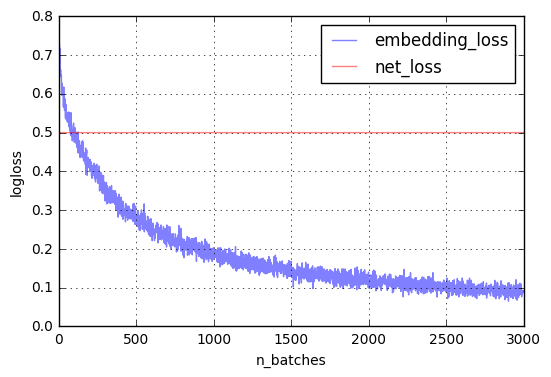

In [18]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1] for x in losses], c='r', label='net_loss', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [23]:
ndcg_vals = []
auc_vals = []
for u in tqdm(ds.data_keys, desc='Prediction', leave=True):
    fd = {
            user_ids:  (np.ones(N_ITEMS)*u).astype(np.int32), 
            left_ids:  np.array([i for (i, r) in ds.test[u]]).astype(np.int32),
        }
    response = sess.run(embedding_left, feed_dict=fd)[:, 0]

    # make relevances
    relevances = np.array([r for (i, r) in ds.test[u]])
    predicted_ranking = np.argsort(-response)
    # calc score
    ndcg_vals.append(ndcg_at_k(relevances[predicted_ranking], 10, method=1))

Prediction: 100%|██████████| 5286/5286 [00:03<00:00, 1391.71it/s] 2%|▏         | 99/5286 [00:00<00:05, 985.85it/s]


In [24]:
np.mean(ndcg_vals)

0.81497388854688324